In [2]:
import netCDF4 as nc 

import numpy as np
import pandas as pd
import os, sys
import time
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (12,7)

from glob import glob

# jupyter用
from IPython.display import clear_output

In [3]:
sys.path.append('../')

In [4]:
from dep.mask import (binary_padding, 
                      binary_interpret,
                     bitmask_unpack, 
                     qa_dict)

# Check file structure

In [2]:
fpath = 'D:/download/AVHRR-Land_19850104.nc'

In [3]:
with nc.Dataset(fpath, 'r') as ds:
    print(ds.variables.keys())

dict_keys(['latitude', 'longitude', 'time', 'crs', 'lat_bnds', 'lon_bnds', 'SREFL_CH1', 'SREFL_CH2', 'BT_CH3', 'BT_CH4', 'BT_CH5', 'SREFL_CH3', 'SZEN', 'VZEN', 'RELAZ', 'TIMEOFDAY', 'QA'])


# Land and water masking

In [5]:
fpath = 'D:/download/AVHRR-Land_19850104.nc'
with nc.Dataset(fpath, 'r') as ds:
    qa = ds.variables['QA'][0,:,:]
    b1 = ds.variables['SREFL_CH1'][0,:,:]

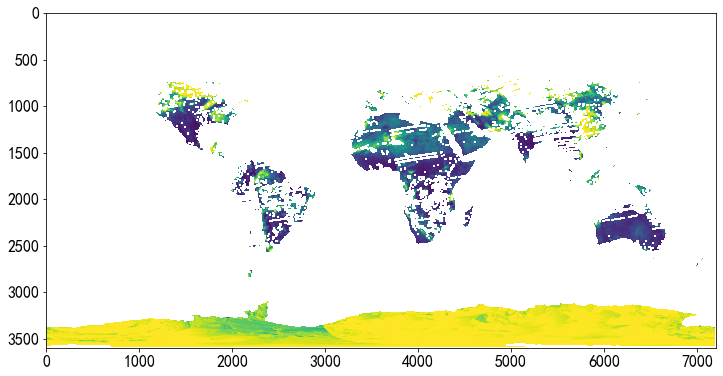

In [10]:
plt.imshow(b1)

In [6]:
L, U = [4000, 1500]
R, D = [L+100, U+100]
ssqa = qa[U:D, L:R]
ssb1 = b1[U:D, L:R]

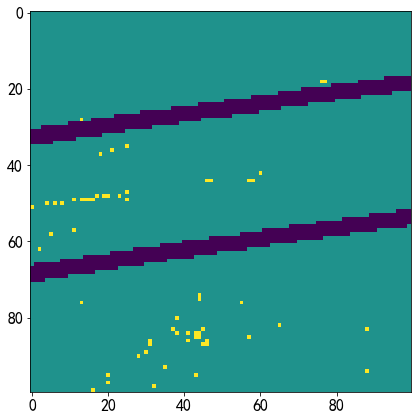

In [11]:
plt.imshow(ssqa)

In [12]:
temp1 = binary_padding(ssqa[-4, -1], 16)
print(temp1)
binary_interpret(temp1)

0b0100000010000000
Pixel is cloudy
Channel 1 value is invalid


In [13]:
qa_masks = bitmask_unpack(ssqa)

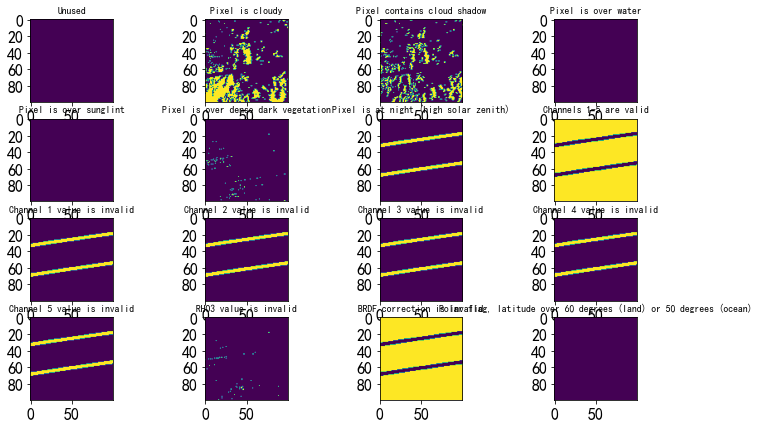

In [15]:
fig, ax = plt.subplots(4, 4)
plt.rcParams['font.size'] = 8
ax = ax.flatten()
for i in range(16):
    ax[i].imshow(qa_masks[i, :,:])
    ax[i].set_title(qa_dict[i])

In [16]:
ssb1 = b1[U:D,L:R]
b1mask = qa_masks[1,:,:]+qa_masks[2,:,:]+qa_masks[3,:,:]
b1mask_invalid = np.where(b1mask>0, 0, 1)
test_b1mask = ssb1*b1mask_invalid * qa_masks[7,:,:]
test_b1mask = np.where(test_b1mask >0, test_b1mask, np.nan)

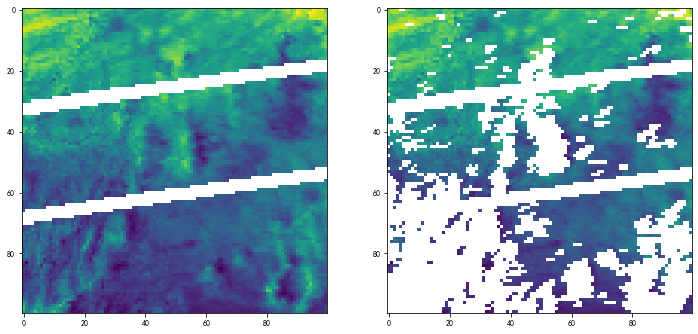

In [17]:
fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].imshow(ssb1)
ax[1].imshow(test_b1mask)

# MODIS v6 Fire cloud mask

In [80]:
fpath = 'D:/download/AVHRR-Land_19850104.nc'
with nc.Dataset(fpath, 'r') as ds:
    qa = ds.variables['QA'][0,:,:]
    b1 = ds.variables['SREFL_CH1'][0,:,:]  #650nm
    b2 = ds.variables['SREFL_CH2'][0,:,:]  #860nm
    b5 = ds.variables['BT_CH5'][0,:,:]     # 12000nm

In [81]:
L, U = [2000, 2000]
boxsize = 1000
R, D = [L+boxsize, U+boxsize]
ssqa = qa[U:D, L:R]
ssb1 = b1[U:D, L:R]
ssb2 = b2[U:D, L:R]
ssb5 = b5[U:D, L:R]

In [82]:
qa_masks = bitmask_unpack(ssqa, width=16)

In [83]:
cond1 = (ssb1 + ssb2 > 1.2)
cond2 = ssb5<265
cond3 = (ssb1 + ssb2 > 0.7) * (ssb5 < 285)
cond4 = (qa_masks[3]) * (ssb2 > 0.25) * (ssb5 < 300)

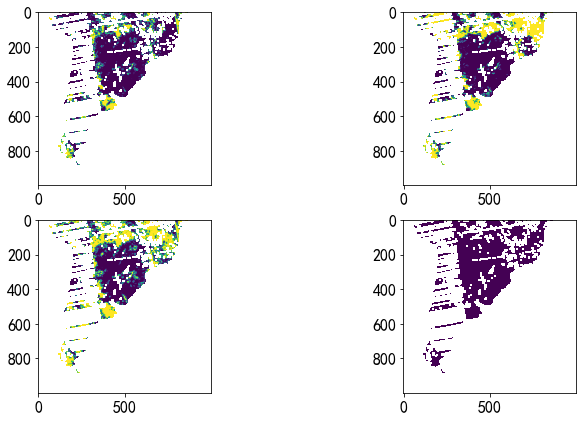

In [84]:
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()
ax[0].imshow(cond1); ax[1].imshow(cond2)
ax[2].imshow(cond3); ax[3].imshow(cond4)

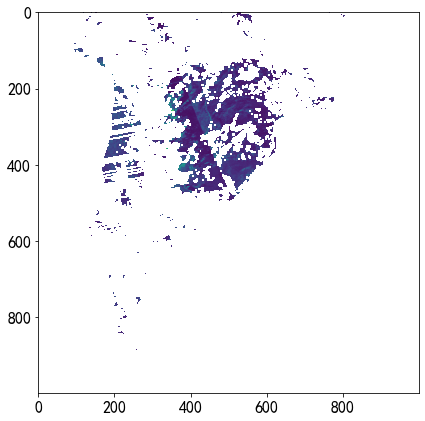

In [85]:
modis_cldmsk = cond1+cond2+cond3+cond4
modis_cldmsk = np.where(modis_cldmsk>0, 0, 1)
b1masked = ssb1*modis_cldmsk
b1masked = np.where(b1masked<=0, np.nan, b1masked)
plt.imshow(b1masked)

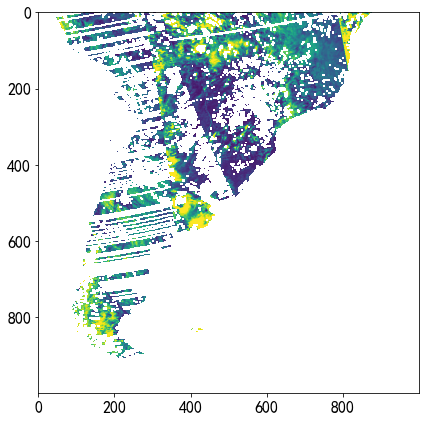

In [86]:
default_cldmsk = qa_masks[1,:,:]+qa_masks[2,:,:]
default_cldmsk = np.where(default_cldmsk>0, 1, 0)
b1masked2 = ssb1*default_cldmsk
b1masked2 = np.where(b1masked2<=0, np.nan, b1masked2)
plt.imshow(b1masked2)

Text(0.5, 1.0, 'Without cloud mask')

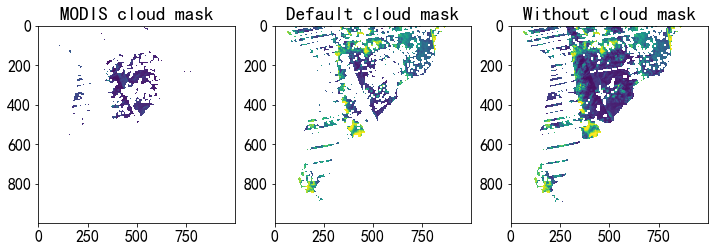

In [87]:
fig, ax = plt.subplots(1, 3)
ax = ax.flatten()
ax[0].imshow(b1masked); ax[0].set_title('MODIS cloud mask') 
ax[1].imshow(b1masked2); ax[1].set_title('Default cloud mask') 
ax[2].imshow(ssb1); ax[2].set_title('Without cloud mask') 


# speed test

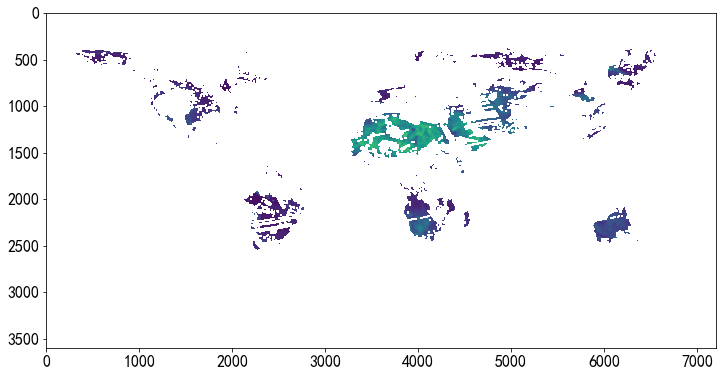

In [79]:
start = time.time()

fpath = 'D:/download/AVHRR-Land_19850707.nc'
with nc.Dataset(fpath, 'r') as ds:
    qa = ds.variables['QA'][0,:,:]
    b1 = ds.variables['SREFL_CH1'][0,:,:]  #650nm
    b2 = ds.variables['SREFL_CH2'][0,:,:]  #860nm
    b5 = ds.variables['BT_CH5'][0,:,:]     # 12000nm

L,R,D,U = [0,7200,3600,0]
ssqa = qa[U:D, L:R]
ssb1 = b1[U:D, L:R]
ssb2 = b2[U:D, L:R]
ssb5 = b5[U:D, L:R]

qa_masks = bitmask_unpack(ssqa, width=16)

cond1 = (ssb1 + ssb2 > 1.2)
cond2 = ssb5<265
cond3 = (ssb1 + ssb2 > 0.7) * (ssb5 < 285)
cond4 = (qa_masks[3]) * (ssb2 > 0.25) * (ssb5 < 300)

modis_cldmsk = cond1+cond2+cond3+cond4
modis_cldmsk = np.where(modis_cldmsk>0, 0, 1) # >0 means pixels should be masked
b1masked = ssb1*modis_cldmsk
b1masked = np.where(b1masked<=0, np.nan, b1masked)
fig, ax = plt.subplots()
ax.imshow(b1masked)
fig.savefig('../note/mask_0704.png', bbox_inches='tight')

end = time.time()

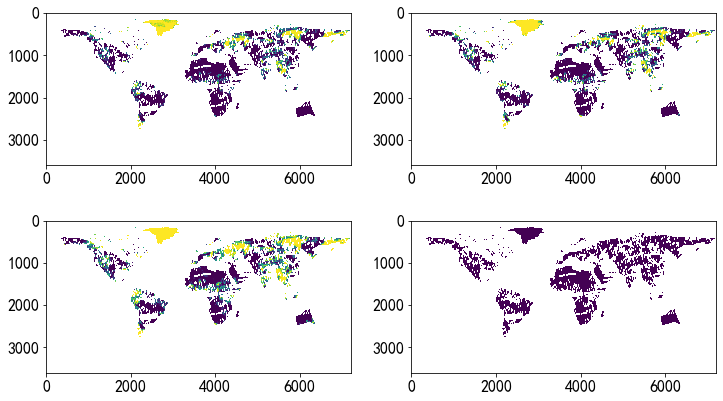

In [78]:
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()
ax[0].imshow(cond1); ax[1].imshow(cond2)
ax[2].imshow(cond3); ax[3].imshow(cond4)

In [69]:
print(f'time elapsed: {end-start}s')

time elapsed: 23.998228073120117s


In [67]:
print(f'time elapsed: {end-start}s')

time elapsed: 19.06477379798889s
